In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import h10
from tqdm import tqdm
from nicks_plot_utils import *

import boost_histogram as bh

In [2]:
root_reader = h10.h10_mc()
root_reader.add("aao_norad.root")

In [3]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

def calc_W(float e_prime_px, float e_prime_py, float e_prime_pz, float e_prime_E):
    # cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    # cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    # cdef float e_prime_pz = e_p*cos(e_theta)
    # cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    
    
    return temp3


def calc_q2(float e_prime_px, float e_prime_py, float e_prime_pz, float e_prime_E):
    # cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    # cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    # cdef float e_prime_pz = e_p*cos(e_theta)
    # cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2

In [4]:
wvsq2 = bh.Histogram(bh.axis.Regular(150, 1.1, 2.0),
                     bh.axis.Regular(150, 1.0, 3.5))

w = bh.Histogram(bh.axis.Regular(150, 1.1, 2.0))


with tqdm(total=root_reader.num_entries) as pbar:
    for i, event in enumerate(root_reader):
        pbar.update(1)
        # if i > 500000: break
        if i % 100 == 0: pbar.update(1)
        
        W = calc_W(event.pxpart[0],event.pypart[0],event.pzpart[0],event.epart[0])
        Q2 = calc_q2(event.pxpart[0],event.pypart[0],event.pzpart[0],event.epart[0])
        
        wvsq2.fill(W,Q2)
        w.fill(W)
        
        

10000056it [09:44, 17111.37it/s]                             


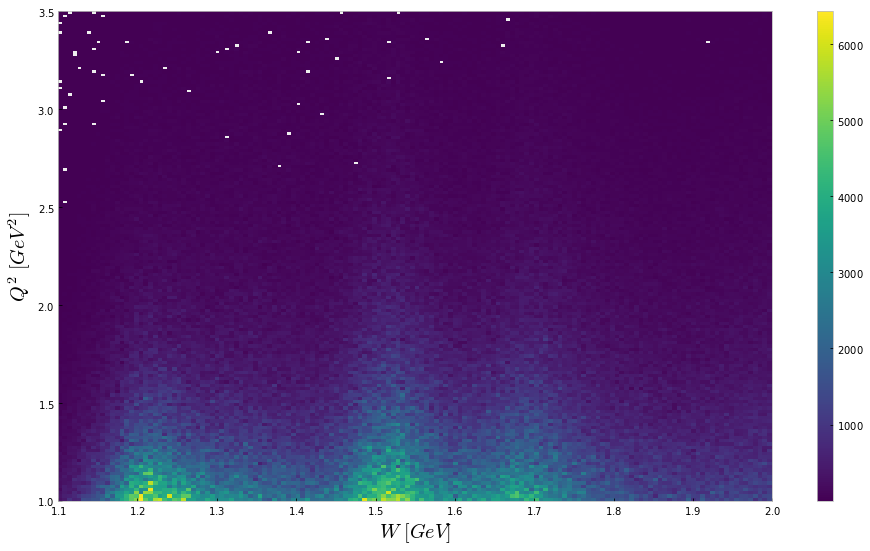

In [5]:
hist = Hist2D(boost_hist=wvsq2, xname="$W~[GeV]$", yname="$Q^2~[GeV^2]$")
hist_W = Hist1D(boost_hist=w, name="$W~[GeV]$")

#hist_W.histogram(label="$W$ Projection", color='r', density=True, factor=3.0)
hist.plot(colorbar=True, density=False, zeros=False)